In [19]:
import re
import uuid

from langchain_core.tools import StructuredTool
from pydantic import BaseModel


def create_tool(company: str) -> dict:
    """Create schema for a placeholder tool."""
    # Remove non-alphanumeric characters and replace spaces with underscores for the tool name
    formatted_company = re.sub(r"[^\w\s]", "", company).replace(" ", "_")

    def company_tool(year: int) -> str:
        # Placeholder function returning static revenue information for the company and year
        return f"{company} had revenues of $100 in {year}."

    return StructuredTool.from_function(
        company_tool,
        name=formatted_company,
        description=f"Information about {company}",
        args_schema={
            "type": "object",
            "properties": {
                "year": {"type": "integer", "description": "年份"},
            },
            "required": ["year"]
        }
    )


# Abbreviated list of S&P 500 companies for demonstration
s_and_p_500_companies = [
    "3M",
    "A.O. Smith",
    "Abbott",
    "Accenture",
    "Advanced Micro Devices",
    "Yum! Brands",
    "Zebra Technologies",
    "Zimmer Biomet",
    "Zoetis",
]

# Create a tool for each company and store it in a registry with a unique UUID as the key
tool_registry = {
    str(uuid.uuid4()): create_tool(company) for company in s_and_p_500_companies
}

tool_registry

{'c4aa440d-6d97-47d1-b30e-4fb6fcaf399d': StructuredTool(name='3M', description='Information about 3M', args_schema={'type': 'object', 'properties': {'year': {'type': 'integer', 'description': '年份'}}, 'required': ['year']}, func=<function create_tool.<locals>.company_tool at 0x13c6a49a0>),
 'c725cc96-5849-45d6-a194-5888b41fa55e': StructuredTool(name='AO_Smith', description='Information about A.O. Smith', args_schema={'type': 'object', 'properties': {'year': {'type': 'integer', 'description': '年份'}}, 'required': ['year']}, func=<function create_tool.<locals>.company_tool at 0x13c6336a0>),
 '0cc07880-f4ec-4037-a29d-d88ef3facee7': StructuredTool(name='Abbott', description='Information about Abbott', args_schema={'type': 'object', 'properties': {'year': {'type': 'integer', 'description': '年份'}}, 'required': ['year']}, func=<function create_tool.<locals>.company_tool at 0x13cc3c0e0>),
 'dd879e04-e375-4c8b-b533-a8e152482138': StructuredTool(name='Accenture', description='Information about Acc

In [20]:
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

tool_documents = [
    Document(
        page_content=tool.description,
        id=id,
        metadata={"tool_name": tool.name},
    )
    for id, tool in tool_registry.items()
]

vector_store = InMemoryVectorStore(embedding=OpenAIEmbeddings())
document_ids = vector_store.add_documents(tool_documents)

In [38]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.messages import SystemMessage, HumanMessage

# Define the state structure using TypedDict.
# It includes a list of messages (processed by add_messages)
# and a list of selected tool IDs.
class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]


builder = StateGraph(State)

# Retrieve all available tools from the tool registry.
tools = list(tool_registry.values())
llm = ChatOpenAI()


# The agent function processes the current state
# by binding selected tools to the LLM.
def agent(state: State):
    # Map tool IDs to actual tools
    # based on the state's selected_tools list.
    selected_tools = [tool_registry[id] for id in state["selected_tools"]]
    print("selected_tools",selected_tools)
    # Bind the selected tools to the LLM for the current interaction.
    llm_with_tools = llm.bind_tools(selected_tools)
    # Invoke the LLM with the current messages and return the updated message list.
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# The select_tools function selects tools based on the user's last message content.
def select_tools(state: State):
    last_user_message = state["messages"][-1]
    query = last_user_message.content
    tool_documents = vector_store.similarity_search(query)
    print("tool_documents",tool_documents)
    return {"selected_tools": [document.id for document in tool_documents]}


builder.add_node("agent", agent)
builder.add_node("select_tools", select_tools)

tool_node = ToolNode(tools=tools)
builder.add_node("tools", tool_node)

builder.add_conditional_edges("agent", tools_condition, path_map=["tools", "__end__"])
builder.add_edge("tools", "agent")
builder.add_edge("select_tools", "agent")
builder.add_edge(START, "select_tools")
graph = builder.compile()

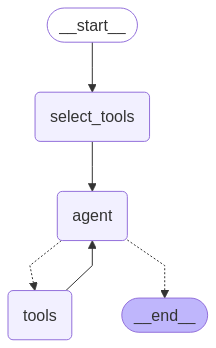

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [39]:
user_input = "Can you give me some information about AMD"

result = graph.invoke({"messages": [("user", user_input)]})

tool_documents [Document(id='acc6fa89-9760-44e7-b334-05eed8817543', metadata={'tool_name': 'Advanced_Micro_Devices'}, page_content='Information about Advanced Micro Devices'), Document(id='0cc07880-f4ec-4037-a29d-d88ef3facee7', metadata={'tool_name': 'Abbott'}, page_content='Information about Abbott'), Document(id='c725cc96-5849-45d6-a194-5888b41fa55e', metadata={'tool_name': 'AO_Smith'}, page_content='Information about A.O. Smith'), Document(id='dd879e04-e375-4c8b-b533-a8e152482138', metadata={'tool_name': 'Accenture'}, page_content='Information about Accenture')]
selected_tools [StructuredTool(name='Advanced_Micro_Devices', description='Information about Advanced Micro Devices', args_schema={'type': 'object', 'properties': {'year': {'type': 'integer', 'description': '年份'}}, 'required': ['year']}, func=<function create_tool.<locals>.company_tool at 0x13cc3c360>), StructuredTool(name='Abbott', description='Information about Abbott', args_schema={'type': 'object', 'properties': {'year':

In [40]:
result

{'messages': [HumanMessage(content='Can you give me some information about AMD', additional_kwargs={}, response_metadata={}, id='862c4309-e2ac-49e0-b700-54eec3397c86'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_musJhNaFcFSCffRaMDKhXOn5', 'function': {'arguments': '{"year":2021}', 'name': 'Advanced_Micro_Devices'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 141, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BQp2tpBIVW8DWqONMo6YurBSiuiVq', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1d0254eb-8c4f-4181-a4e4-528966decbe1-0', tool_calls=[{'name': 'Advanced_Micro_Devices', 'args': {'year': 2021}, 'id': 'call_musJhNaFcFSC

In [45]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode


def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"

tool = StructuredTool.from_function(get_weather)

tools = [tool, get_coolest_cities]
print(tools)
tool_node = ToolNode(tools)



[StructuredTool(name='get_weather', description='Call to get the current weather.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x13cc656c0>), StructuredTool(name='get_coolest_cities', description='Get a list of coolest cities', args_schema=<class 'langchain_core.utils.pydantic.get_coolest_cities'>, func=<function get_coolest_cities at 0x13cc658a0>)]


In [42]:
from typing import Literal


from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model_with_tools = llm.bind_tools(tools)



In [43]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

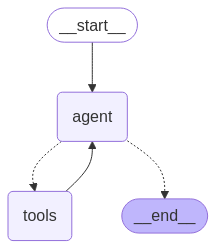

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
for chunk in app.stream(
    {"messages": [("human", "what's the weather?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

what's the weather?
================================== Ai Message ==================================

Sure, I can help you with that. Could you please provide me with the location for which you want to know the weather?


In [57]:
for chunk in app.stream(
    {"messages": [("human", "sf")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

sf
================================== Ai Message ==================================

Sure, I can provide you with the current weather for San Francisco. Let me fetch that information for you.
Tool Calls:
  get_weather (call_K9i9ybuFkF9hIXdqaz9R4hq3)
 Call ID: call_K9i9ybuFkF9hIXdqaz9R4hq3
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The current weather in San Francisco is foggy with a temperature of 60 degrees. If you'd like information on any other cities or need further assistance, feel free to let me know!


/var/folders/_j/wqcd8ng91233tcy8v2c8_88c0000gn/T/ipykernel_34821/1166123341.py:37: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  embeddings = init_embeddings("openai:text-embedding-3-small")


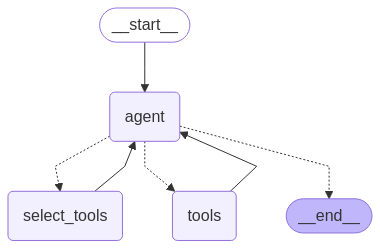

In [5]:
import math
import types
import uuid

from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

from langgraph_bigtool import create_agent
from langgraph_bigtool.utils import (
    convert_positional_only_function_to_tool
)

# Collect functions from `math` built-in
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    if not isinstance(
        function, types.BuiltinFunctionType
    ):
        continue
    # This is an idiosyncrasy of the `math` library
    if tool := convert_positional_only_function_to_tool(
        function
    ):
        all_tools.append(tool)

# Create registry of tools. This is a dict mapping
# identifiers to tool instances.
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

# Index tool names and descriptions in the LangGraph
# Store. Here we use a simple in-memory store.
embeddings = init_embeddings("openai:text-embedding-3-small")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["description"],
    }
)
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

# Initialize agent
llm = init_chat_model("openai:gpt-4o-mini")

builder = create_agent(llm, tool_registry)
agent = builder.compile(store=store)
agent

In [6]:
query = "Use available tools to calculate arc cosine of."

# Test it out
for step in agent.stream(
    {"messages": query},
    stream_mode="updates",
):
    for _, update in step.items():
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_tools (call_cc7gNElBFHbFe3B7tCyekUPO)
 Call ID: call_cc7gNElBFHbFe3B7tCyekUPO
  Args:
    query: arc cosine calculation
================================= Tool Message =================================

Available tools: ['cos', 'acos']
================================== Ai Message ==================================

I have access to the arc cosine function. Please provide the value for which you would like to calculate the arc cosine. The value must be in the range of -1 to 1.


In [8]:
query = "中国的首都是哪里"

# Test it out
for step in agent.stream(
    {"messages": query},
    stream_mode="updates",
):
    for _, update in step.items():
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================

中国的首都是北京。


In [11]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode


def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."
    
def get_email(username: str):
    """Get email address for a given username."""
    return f"{username}@example.com"
    
get_weather_tool = convert_positional_only_function_to_tool(get_weather)
get_email_tool = convert_positional_only_function_to_tool(get_email)

all_tools = [get_weather_tool, get_email_tool]

all_tools


[StructuredTool(name='get_weather', description='Call to get the current weather.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x119cb9260>),
 StructuredTool(name='get_email', description='Get email address for a given username.', args_schema=<class 'langchain_core.utils.pydantic.get_email'>, func=<function get_email at 0x119cb8d60>)]

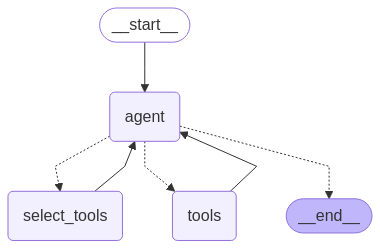

In [12]:
# Create registry of tools. This is a dict mapping
# identifiers to tool instances.
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

# Index tool names and descriptions in the LangGraph
# Store. Here we use a simple in-memory store.
embeddings = init_embeddings("openai:text-embedding-3-small")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["description"],
    }
)
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

# Initialize agent
llm = init_chat_model("openai:gpt-4o-mini")

builder = create_agent(llm, tool_registry)
agent = builder.compile(store=store)
agent

In [15]:
query = "sf"

# Test it out
for step in agent.stream(
    {"messages": query},
    stream_mode="updates",
):
    for _, update in step.items():
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_tools (call_9JV59XcjgRFgsT1Jh00PeggL)
 Call ID: call_9JV59XcjgRFgsT1Jh00PeggL
  Args:
    query: sf
================================= Tool Message =================================

Available tools: ['get_weather', 'get_email']
================================== Ai Message ==================================

It seems like you mentioned "sf." Could you please clarify if you are looking for information about San Francisco, weather, or anything else related to "sf"?
